# Paper

In [1]:
import os
os.chdir(os.path.abspath(".."))

### Feature importance

In [2]:
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

from dataio import load_metadataset

sns.set_theme(style="whitegrid")

feature_set_importances = dict()
for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    meta_X, meta_y = load_metadataset(feature_set, problem_type="regression")
    y_encoder = LabelEncoder().fit(meta_y)
    meta_y_encoded = y_encoder.transform(meta_y)

    xgb = XGBClassifier().fit(meta_X, meta_y_encoded)
    feature_importances = xgb.feature_importances_
    
    importance_map = dict()
    for fname, fimp in zip(meta_X.columns, feature_importances):
        fname_split = fname.split("_")
        if fname_split[0] in ["mean", "std", "median", "q1", "q3", "max", "min"]:
            fname_proper = "_".join(fname_split[1:])
            importance_map[fname_proper] = fimp + importance_map.get(fname_proper, 0.)
        else:
            importance_map[fname] = fimp + importance_map.get(fname, 0.)

    imps = np.array(list(importance_map.values()))
    names = np.array(list(importance_map.keys()))
    order = np.argsort(-imps)

    feature_set_importances[feature_set] = {
        "name": names[order],
        "importance": imps[order]
    }

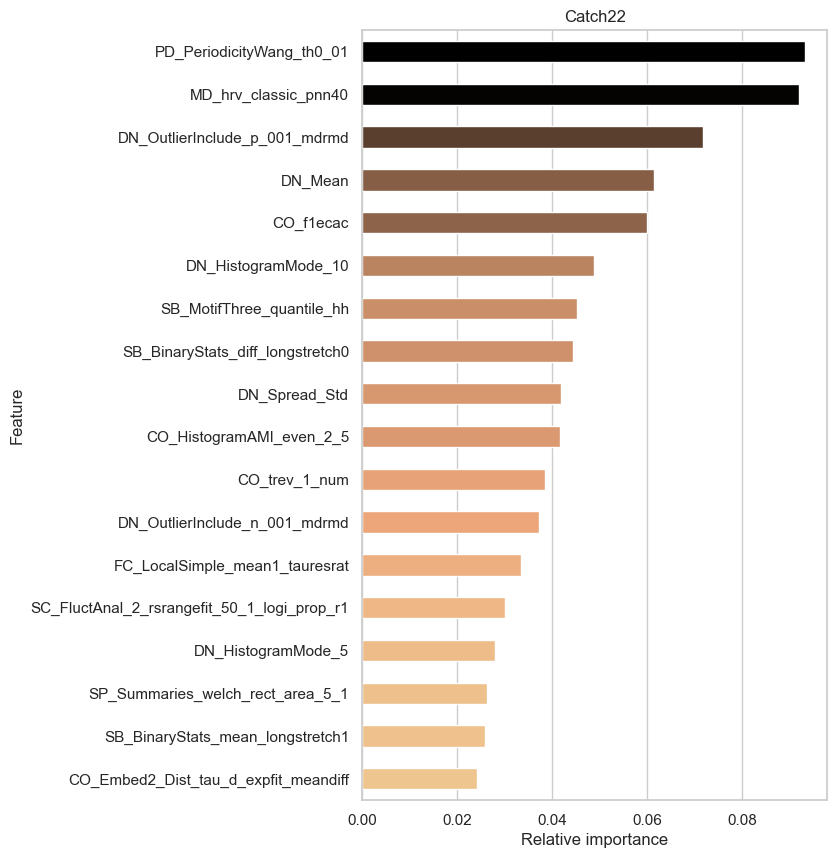

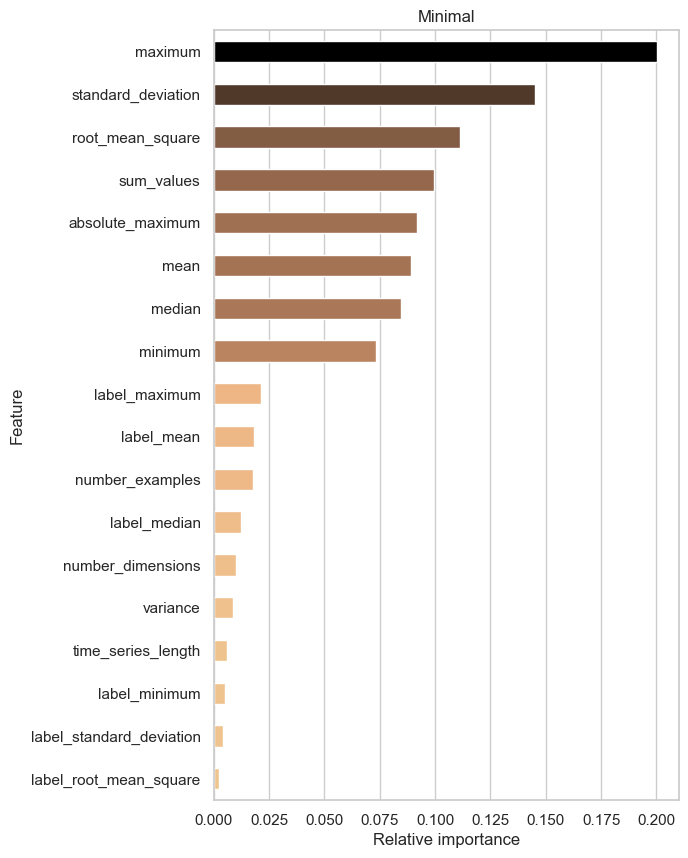

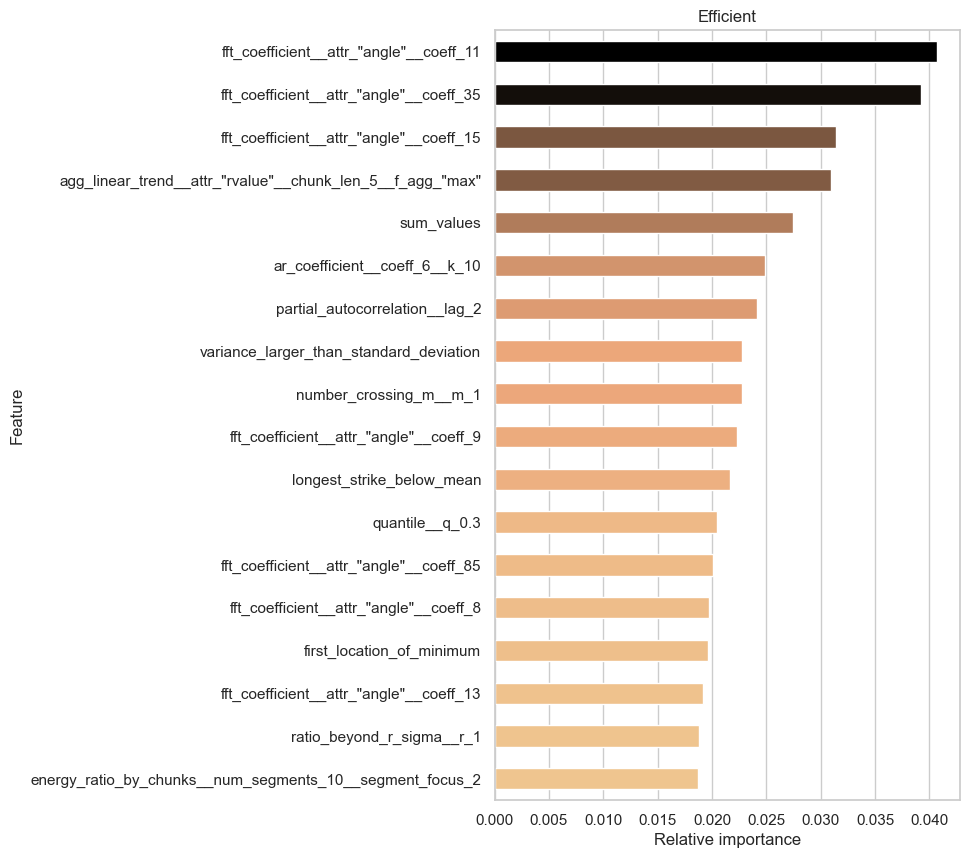

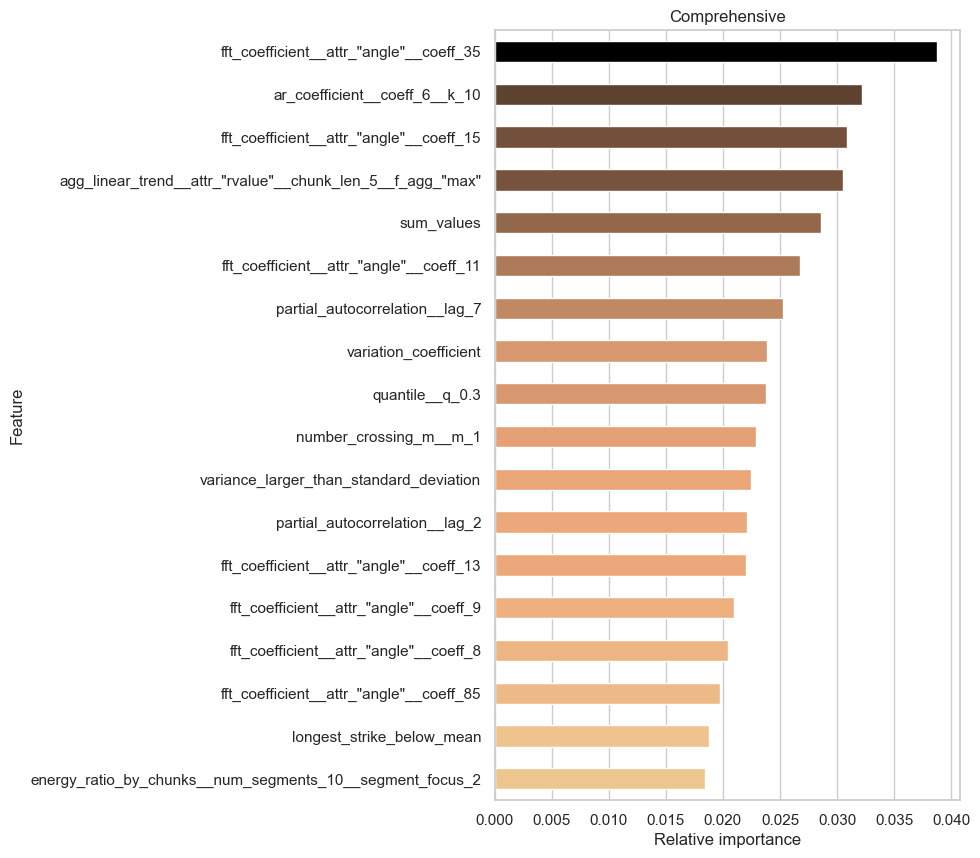

In [4]:
import matplotlib.pyplot as plt

n_features = 18
for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    fig, ax = plt.subplots(figsize=(6, 10))

    sns.barplot(
        x=feature_set_importances[feature_set]["importance"][:n_features],
        y=feature_set_importances[feature_set]["name"][:n_features],
        hue=-feature_set_importances[feature_set]["importance"][:n_features],
        legend=False,
        palette="copper",
        width=0.5,
        ax=ax
    )
    ax.set_xlabel("Relative importance")
    ax.set_ylabel("Feature")
    ax.set_title(feature_set.capitalize())

    plt.savefig(f'visualization/regression/{feature_set}_feature_importance.pdf', bbox_inches='tight')

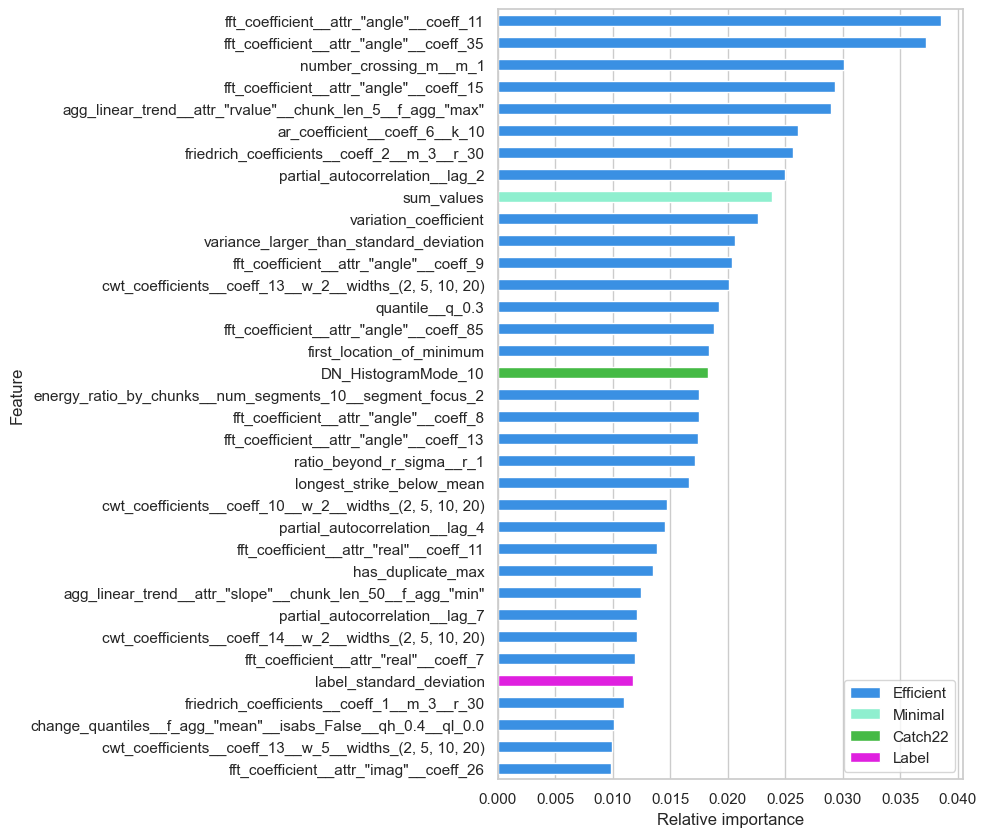

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

meta_X_tsfresh, meta_y = load_metadataset("comprehensive", "regression")
meta_X_catch22, _ = load_metadataset("catch22", "regression")
meta_X = pd.concat([meta_X_tsfresh, meta_X_catch22], axis=1)
meta_X = meta_X.T.drop_duplicates().T

y_encoder = LabelEncoder().fit(meta_y)
meta_y_encoded = y_encoder.transform(meta_y)

xgb = XGBClassifier().fit(meta_X, meta_y_encoded)
feature_importances = xgb.feature_importances_

importance_map = dict()
for fname, fimp in zip(meta_X.columns, feature_importances):
    fname_split = fname.split("_")
    if fname_split[0] in ["mean", "std", "median", "q1", "q3", "max", "min"]:
        fname_proper = "_".join(fname_split[1:])
        importance_map[fname_proper] = fimp + importance_map.get(fname_proper, 0.)
    else:
        importance_map[fname] = fimp + importance_map.get(fname, 0.)

imps = np.array(list(importance_map.values()))
names = np.array(list(importance_map.keys()))
order = np.argsort(-imps)

hue = list()
for name in names:
    if name in ["number_examples", "time_series_length"]:
        hue.append("General")
    elif name.startswith("label_"):
        hue.append("Label")
    elif name in feature_set_importances["catch22"]["name"]:
        hue.append("Catch22")
    elif name in feature_set_importances["minimal"]["name"]:
        hue.append("Minimal")
    elif name in feature_set_importances["efficient"]["name"]:
        hue.append("Efficient")
    else:
        hue.append("Comprehensive")
hue = np.array(hue)
colors = {
    "Minimal": "aquamarine",
    "Efficient": "dodgerblue",
    "Comprehensive": "midnightblue",
    "Catch22": "limegreen",
    "General": "red",
    "Label": "magenta"
}

n_features = 35
fig, ax = plt.subplots(figsize=(6, 10))
sns.barplot(
    x=imps[order][:n_features],
    y=names[order][:n_features],
    width=0.5,
    hue=hue[order][:n_features],
    palette=colors,
    ax=ax
)
ax.set_xlabel("Relative importance")
ax.set_ylabel("Feature")

#plt.savefig(f'visualization/regression/every_feature_importance.pdf', bbox_inches='tight')
plt.show()

### Intra-comparison

In [27]:
import pandas as pd

from dataio import load_rmses
from MCM import MCM

results = dict()
for model in ["svm", "nb", "1nn", "5nn"]:
    for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
        res = pd.read_csv(f"results/regression/{feature_set}/regression_label_{feature_set}_{model}.csv")
        results[f"{model}-{feature_set}"] = res["rmse"]

for model in ["rf", "xgb"]:
    for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
        rmse = None
        for i in range(5):
            res = pd.read_csv(f"results/regression/{feature_set}/{model}/regression_label_{feature_set}_{model}_{i+1}.csv")
            if rmse is None:
                rmse = res["rmse"]
            else:
                rmse = rmse + res["rmse"]
        rmse = rmse / 5
        results[f"{model}-{feature_set}"] = rmse

rmses = load_rmses()
results["datasets"] = rmses.columns

results = pd.DataFrame(results).set_index("datasets")

for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    comparison = results[[
        f"svm-{feature_set}",
        f"nb-{feature_set}",
        f"1nn-{feature_set}",
        f"5nn-{feature_set}",
        f"rf-{feature_set}",
        f"xgb-{feature_set}",
    ]]
    feature_set_cap = feature_set.capitalize()
    comparison.columns = [f"SVM-{feature_set_cap}", f"NB-{feature_set_cap}", f"1NN-{feature_set_cap}", f"5NN-{feature_set_cap}", f"RF-{feature_set_cap}", f"XGB-{feature_set_cap}"]

    # Relative RMSE
    comparison = (comparison.T / (comparison.T + comparison.T.median())).T

    MCM.compare(
        df_results=comparison,
        output_dir="visualization/regression/",
        pdf_savename=f"{feature_set}-comparisons",
        used_statistic="Relative RMSE",
        order_WinTieLoss="lower",
        order_better="increasing",
        save_as_json=False,
        win_label="Wins",
        tie_label="Ties",
        loss_label="Losses",
        colormap="coolwarm",
        fig_size=(12,6),
        font_size=9,
    )

Processing XGB-Comprehensive, RF-Comprehensive:   0%|          | 0/6 [00:00<?, ?it/s] 


### Inter-comparison

In [28]:
import pandas as pd

from dataio import load_rmses
from metamodel import build_baseline
from MCM import MCM

results = dict()
for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    model = "rf" if feature_set == "minimal" else "xgb"
    rmse = None
    for i in range(5):
        res = pd.read_csv(f"results/regression/{feature_set}/{model}/regression_label_{feature_set}_{model}_{i+1}.csv")
        if rmse is None:
            rmse = res["rmse"]
        else:
            rmse = rmse + res["rmse"]
    rmse = rmse / 5
    results[f"{model}-{feature_set}"] = rmse

rmses = load_rmses()
results["datasets"] = rmses.columns
results["DrCIF"] = rmses.loc["DrCIF"].reset_index(drop=True)
results["baseline"] = build_baseline(rmses)

results = pd.DataFrame(results).set_index("datasets")
results.columns = ["XGB-Catch22", "RF-Minimal", "XGB-Efficient", "XGB-Comprehensive", "DrCIF", "Baseline"]

# Relative RMSE
results = (results.T / (results.T + results.T.median())).T

MCM.compare(
    df_results=results,
    output_dir="visualization/regression/",
    pdf_savename=f"all-comparisons",
    used_statistic="Relative RMSE",
    order_WinTieLoss="lower",
    order_better="increasing",
    save_as_json=False,
    win_label="Wins",
    tie_label="Ties",
    loss_label="Losses",
    colormap="coolwarm",
    fig_size=(12,6),
    font_size=9,
)

Processing Baseline, DrCIF:   0%|          | 0/6 [00:00<?, ?it/s]                 
